<a href="https://colab.research.google.com/github/parshwa1999/Map-Segmentation/blob/master/ResNet_RoadTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation of Road from Satellite imagery

## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
#from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Model, load_model
from skimage.morphology import label
import pickle
from keras import backend as K

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt
import h5py

seed = 56

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')
base_path = "gdrive/My\ Drive/MapSegClean/"
%cd gdrive/My\ Drive/MapSegClean/

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/MapSegClean


## Defining Custom Loss functions and accuracy Metric.

In [0]:
#Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
  return iou

In [0]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

## Defining Our Model

In [5]:
pip install -U segmentation-models

Requirement already up-to-date: segmentation-models in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [6]:
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
import keras

from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

Segmentation Models: using `keras` framework.


In [7]:
model = Unet('resnet101', input_shape=(256, 256, 3), encoder_weights=None)
#model = Unet(input_shape=(256, 256, 3), weights=None, activation='elu')
model.summary()

# fit model















Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
_______________________________________________________________________________

### HYPER_PARAMETERS

In [0]:
LEARNING_RATE = 0.0001

### Initializing Callbacks

In [0]:
#from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

In [0]:
model_path = "./Models/Resnet_road_weights.h5"
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystopper = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4)

### Compiling the model

In [11]:
opt = keras.optimizers.adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef])

## Testing our Model

### On Test Images

In [0]:
model.load_weights("Models/Resnet_road_weights.h5")

In [15]:
import cv2
import glob
import numpy as np
import h5py

#test_images = np.array([cv2.imread(file) for file in glob.glob("/home/bisag/Desktop/Road-Segmentation/I/")])
#test_masks = np.array([cv2.imread(file) for file in glob.glob("/home/bisag/Desktop/Road-Segmentation/M/")])
test_masks = []
test_images = []
files = glob.glob ("TestI/*.png")
for myFile in files:
    print(myFile)
    image = cv2.imread (myFile)
    test_images.append (image)
    myFile = 'TestM' + myFile[5:len(myFile)]
    image = cv2.cvtColor(cv2.imread (myFile), cv2.COLOR_BGR2GRAY)
    test_masks.append (image)


#files = glob.glob ("TestM/*.png")
#for myFile in files:
#    print(myFile)

    
#test_images = cv2.imread("/home/bisag/Desktop/Road-Segmentation/I/1.png")
#test_masks = cv2.imread("/home/bisag/Desktop/Road-Segmentation/M/1.png")

test_images = np.array(test_images)
test_masks = np.array(test_masks)

test_masks = np.expand_dims(test_masks, -1)
print("Unique elements in the train mask:", np.unique(test_masks))

print(test_images.shape)
print(test_masks.shape)

test_images = test_images.astype(np.float16)/255
test_masks = test_masks.astype(np.float16)/255


TestI/10378690_15_24.png
TestI/10378690_15_4.png
TestI/10228705_15_22.png
TestI/10378675_15_14.png
TestI/10078690_15_18.png
TestI/10228660_15_20.png
TestI/10378675_15_4.png
TestI/10078735_15_25.png
TestI/10228675_15_22.png
TestI/10078690_15_16.png
TestI/10228735_15_20.png
TestI/10078720_15_14.png
TestI/10378675_15_24.png
TestI/10378690_15_5.png
TestI/10078660_15_4.png
TestI/10228705_15_24.png
TestI/10228735_15_13.png
TestI/10228720_15_2.png
TestI/10378660_15_19.png
TestI/10378675_15_13.png
TestI/10228705_15_7.png
TestI/10228765_15_25.png
TestI/10228675_15_6.png
TestI/10228675_15_9.png
TestI/10228720_15_16.png
TestI/10228705_15_19.png
TestI/10228750_15_12.png
TestI/10078720_15_18.png
TestI/10228675_15_14.png
TestI/10228750_15_5.png
Unique elements in the train mask: [  0 255]
(30, 256, 256, 3)
(30, 256, 256, 1)


In [16]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                   test_images: 11.3 MiB
                    test_masks:  3.8 MiB
                         image: 64.1 KiB
                        Conv2D:  2.0 KiB
            BatchNormalization:  2.0 KiB
                  MaxPooling2D:  1.4 KiB
                 EarlyStopping:  1.4 KiB
               ModelCheckpoint:  1.4 KiB
             ReduceLROnPlateau:  1.4 KiB
                            _i:  1.2 KiB


In [0]:
test_masks_tmp = []
for i in test_masks:
    image = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
    test_masks_tmp.append (image)

test_images = np.array(test_images)
test_masks = np.array(test_masks_tmp)

test_masks = np.expand_dims(test_masks, -1)

#print(np.unique(test_masks))
print(test_images.shape)
print(test_masks.shape)
del test_masks_tmp

In [17]:
model.evaluate(test_images, test_masks)

30/30 [==============================] - 18s 584ms/step


[0.1354445070028305, 0.6113507747650146]

In [18]:
predictions = model.predict(test_images, verbose=1)

30/30 [==============================] - 17s 555ms/step


In [0]:
thresh_val = 0.1
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

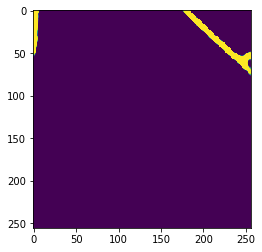

In [37]:
plt.figure()
#plt.subplot(2, 1, 1)
plt.imshow(np.squeeze(predictions[19][:,:,0]))
plt.show()



In [0]:
import matplotlib

for i in range(len(predictions)):
    #print("Results/" + str(i) + "Image.png")
    matplotlib.image.imsave( "Results/" + str(i) + "Image.png"  , np.squeeze(test_images[i][:,:,0]))
    matplotlib.image.imsave( "Results/" + str(i) + "GroundTruth.png"  , np.squeeze(test_masks[i][:,:,0]))
    #cv2.imwrite( "/home/bisag/Desktop/Road-Segmentation/Results/" + str(i) + "Prediction.png"  , np.squeeze(predictions[i][:,:,0]))
    #cv2.imwrite( "/home/bisag/Desktop/Road-Segmentation/Results/" + str(i) + "Prediction_Threshold.png"  , np.squeeze(predicton_threshold[i][:,:,0]))
    #matplotlib.image.imsave('/home/bisag/Desktop/Road-Segmentation/Results/000.png', np.squeeze(predicton_threshold[0][:,:,0]))
    matplotlib.image.imsave("Results/" + str(i) + "Prediction.png"  , np.squeeze(predictions[i][:,:,0]))
    matplotlib.image.imsave( "Results/" + str(i) + "Prediction_Threshold.png"  , np.squeeze(predicton_threshold[i][:,:,0]))

    #imshow(np.squeeze(predictions[0][:,:,0]))


#import scipy.misc
#scipy.misc.imsave('/home/bisag/Desktop/Road-Segmentation/Results/00.png', np.squeeze(predictions[0][:,:,0]))

In [0]:
model.load_weights("/home/parshwa/Desktop/Road-Segmentation/Models/weights.h5")

### Just Test

In [0]:
"""Test"""
import cv2
import glob
import numpy as np
import h5py

#test_images = np.array([cv2.imread(file) for file in glob.glob("/home/bisag/Desktop/Road-Segmentation/I/")])
#test_masks = np.array([cv2.imread(file) for file in glob.glob("/home/bisag/Desktop/Road-Segmentation/M/")])

test_images = []
files = glob.glob ("/home/parshwa/Desktop/Road-Segmentation/Test/*.png")
for myFile in files:
    print(myFile)
    image = cv2.imread (myFile)
    test_images.append (image)


    
#test_images = cv2.imread("/home/bisag/Desktop/Road-Segmentation/I/1.png")
#test_masks = cv2.imread("/home/bisag/Desktop/Road-Segmentation/M/1.png")

test_images = np.array(test_images)

print(test_images.shape)



In [0]:
predictions = model.predict(test_images, verbose=1)

In [0]:
thresh_val = 0.1
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

In [0]:
import matplotlib

for i in range(len(predictions)):
    cv2.imwrite( "/home/parshwa/Desktop/Road-Segmentation/Results/" + str(i) + "Image.png"  , np.squeeze(test_images[i][:,:,0]))
    #cv2.imwrite( "/home/bisag/Desktop/Road-Segmentation/Results/" + str(i) + "Prediction.png"  , np.squeeze(predictions[i][:,:,0]))
    #cv2.imwrite( "/home/bisag/Desktop/Road-Segmentation/Results/" + str(i) + "Prediction_Threshold.png"  , np.squeeze(predicton_threshold[i][:,:,0]))
    #matplotlib.image.imsave('/home/bisag/Desktop/Road-Segmentation/Results/000.png', np.squeeze(predicton_threshold[0][:,:,0]))
    matplotlib.image.imsave("/home/parshwa/Desktop/Road-Segmentation/Results/" + str(i) + "Prediction.png"  , np.squeeze(predictions[i][:,:,0]))
    matplotlib.image.imsave( "/home/parshwa/Desktop/Road-Segmentation/Results/" + str(i) + "Prediction_Threshold.png"  , np.squeeze(predicton_threshold[i][:,:,0]))

    #imshow(np.squeeze(predictions[0][:,:,0]))

imshow(np.squeeze(predictions[0][:,:,0]))

#import scipy.misc
#scipy.misc.imsave('/home/bisag/Desktop/Road-Segmentation/Results/00.png', np.squeeze(predictions[0][:,:,0]))

In [0]:
"""Visualise"""
def layer_to_visualize(layer):
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img_to_visualize)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)

    n = convolutions.shape[0]
    n = int(np.ceil(np.sqrt(n)))

    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
    for i in range(len(convolutions)):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[i], cmap='gray')
